## Topic Modeling IMDB Movie Reviews
### DS 7337 - Natural Laguage Processing - FInal Project
#### George C. Sturrock
##### April 14, 2019
In the final project for Natural Language Processing, topic modelling of the IMDB movies reviews collected in prior assignments will be the base data set.  The movie review data is automatically scrapped from IMDB.  The data will then be evaluated using Latent Dirichlet Allocation (LDA) 
to produce the topic models.  This project will focus on different data preparation techniques to produce topic models.  Using the raw review text, lemmatized review text, named entities, and hypernyms mixed with named entities will be explored for comparison.
##### Resources
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
#### Import Libraries

In [1]:
import platform; print("Platform:", platform.platform())
import os
import sys; print("Python:", sys.version)
import requests; print("Requests:", requests.__version__)
from urllib import request; ("urllib:", request.__version__)
import warnings
warnings.filterwarnings('ignore')
from time import sleep

#Web Scraping
import bs4; print("BeatifulSoup:", bs4.__version__)
from bs4 import BeautifulSoup
import json; print("json:", json.__version__)

#Python Basics
import numpy as np; print("Numpy Version:", np.__version__)
import pandas as pd; print("Pandas Version:", pd.__version__)
from matplotlib import pyplot as plt
import seaborn as sns;
import string

#scikit learn
from sklearn import metrics
from sklearn.feature_extraction import stop_words
#print(stop_words.ENGLISH_STOP_WORDS)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV

import pattern; print("Pattern Version:", pattern.__version__)
from pattern.en import tag, parse, Sentence, parsetree, suggest, lemma, wordnet
from pattern.vector import Document, Model, TFIDF, TF, words, stem, PORTER, LEMMA

#pyLDAvis
import pyLDAvis; print("pyLDAvis Versoin:", pyLDAvis.__version__)
import pyLDAvis.sklearn

Platform: Windows-10-10.0.14393-SP0
Python: 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Requests: 2.21.0
BeatifulSoup: 4.7.1
json: 2.0.9
Numpy Version: 1.16.2
Pandas Version: 0.24.2
Pattern Version: 3.6
pyLDAvis Versoin: 2.1.2


### Data Acquisition
Rocky, Rocky 3 and Rocky 5 will be utilized to collect reviews for noun phrase chunking.  Link to the main user review page for each of the three movies are shown below.  To assure both positive and negative reviews are collected, there are two links per movie.  One is sorted descending by user rating.  The other is sorted ascending by user rating.  Both links have "spoiler alert" messages suppressed as these reviews are often more akin to a summarization of the movie plot instead of a true review.  

In [3]:
#Rocky movie list.  Two links for each movie to assure positive and negative reviews are captured.  
#Sort descending by Review Rating.  Sort ascending by Review Rating.

#Rocky
rockyDict = {"aRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0", 
         "dRocky":"https://www.imdb.com/title/tt0075148/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0", 
#Rocky 5
         "dRocky 5":"https://www.imdb.com/title/tt0100507/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 5":"https://www.imdb.com/title/tt0100507/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0",
#Rocky 3
         "dRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=desc&ratingFilter=0",
         "aRocky 3":"https://www.imdb.com/title/tt0084602/reviews?spoiler=hide&sort=userRating&dir=asc&ratingFilter=0"
            }

rockyKeys = rockyDict.keys()

#### Web Scraping IMDB Movie Review Titles
The individual links to the user reviews are collected below.  A get request uses each of the links in the "rockyDict" python dictionary.  The response is parsed by Beautiful Soup to find the individual links to each individual review.  The review URLs along with the movie name are written to a dataframe named dfRockyReviews.

In [4]:
reviewUrls = list()
dfRockyReviews = pd.DataFrame(columns = ['Movie', 'ReviewURL'])

for r in rockyKeys:
    #print(r, rockyDict[r])
    response = requests.get(rockyDict[r])
    soup = BeautifulSoup(response.text, 'html.parser')
    rUrls = ["http:" + s.attrs['href'] for s in soup.find_all(href = True, class_ = 'title')]
    reviewUrls = reviewUrls + rUrls
    for u in rUrls:
        dfRockyReviews = dfRockyReviews.append({'Movie':r[1:], 'ReviewURL':u}, ignore_index=True)

A sample of the dfRockyReviews dataframe is shown below.

In [5]:
dfRockyReviews[0:5]

,Movie,ReviewURL
0,Rocky,http:/review/rw0149538/
1,Rocky,http:/review/rw4247059/
2,Rocky,http:/review/rw0149534/
3,Rocky,http:/review/rw3647093/
4,Rocky,http:/review/rw1979442/


#### Web Scraping IMDB Movie Review Details
The individual review URLs collected above will be requested and parsed to retrieve key qualitative and categorical data about each review along with the review text itself.  These details are stored in a new dataframe named dfReviewDetails.  The first five records are this dataframe are shown below.

In [6]:
dfReviewDetails = pd.DataFrame(columns=['Movie', 'ReviewUrl', 'ReviewDate', 'ReviewTitle', 'Review', 'Rating', 
                                        'Language'])
counter = 0

for r in reviewUrls:
    fullUrl = "https://www.imdb.com" + r[5:]
    response2 = requests.get(fullUrl)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    rjson = soup2.find('script', type = 'application/ld+json').text
    rjson = json.loads(rjson)
    
    try:
        rating = rjson['reviewRating']['ratingValue']
    except Exception as e:
        #print("No User Rating")
        rating = 5
        
    ### Add stemming logic to review body
    
    dfReviewDetails = dfReviewDetails.append({'Movie':dfRockyReviews.Movie[counter], 'ReviewUrl':r, 
                                              'ReviewDate':rjson['dateCreated'], 'ReviewTitle':rjson['name'], 
                                              'Review':rjson['reviewBody'], 'Rating':rating, 
                                              'Language':rjson['inLanguage']}, ignore_index=True)
    counter += 1

dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language
0,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English
1,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English
3,Rocky,http:/review/rw3647093/,2017-02-24,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,3,English
4,Rocky,http:/review/rw1979442/,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English


The bar plot below shows movie review ratings for the reviews collected in the prior step. The original "Rocky" is widely considered the best of the "Rocky" series.  It won multiple Oscars and introduced "Steady-Cam" technology to the movie world.  However, the Rocky 3 has the highest average user rating of the reviews collected.  Rocky 5 is a truly horrible movie, and the user ratings back up that statement.  

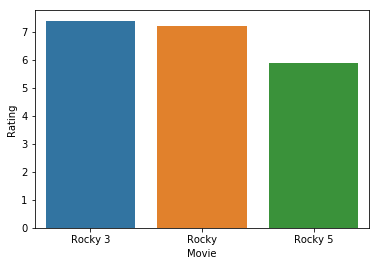

In [7]:
plotdf = dfReviewDetails.sort_values(by=['ReviewDate'])
plotdf.Rating = plotdf.Rating.astype('int64')
plotdf.ReviewDate = pd.to_datetime(plotdf.ReviewDate)
plotdf = plotdf.groupby(['Movie']).mean().reset_index()
sns.barplot(x='Movie', y='Rating', data=plotdf.sort_values(by=['Rating'], ascending=False))

### Data Engineering
The data engineering section contains the methods used to cleanse, process, and attach lists to the dfReviewDetails dataframe.  
#### Create Additional Features for Topic Modeling
The code chunk shown below performs the steps needed to strip punctuation from the raw text reviews.  Then, three different lists are populated to hold named entities, hypernyms, and lemmatized forms of the raw review text.  The lists are then strung back together per row and added to the dfReviewDetails dataframe.

In [8]:
nerList = []
hypernymList = []
lemmaList = []

sw = stop_words.ENGLISH_STOP_WORDS
table = str.maketrans('', '', string.punctuation)

#tx = tag(dfReviewDetails.Review[2], tokenize=True)

#Create Lemmatize, NER, Hypernyms version of each review for topic modeling
for dfr in dfReviewDetails.Review:
    tlist = []
    poslist = []
    nlist = []
    hlist = []
    t1 = tag(dfr, tokenize=True)
    for t, pos in t1:
        if t not in sw and t not in string.punctuation:
            if pos != "NNPS" and pos != "NNP":
                tlist.append(lemma(t))
                poslist.append(pos)
            else:
                nlist.append(t)
                tlist.append(t)
                poslist.append(pos)
            if pos.startswith("N") or pos.startswith("V"):
                if pos == "NNPS" or pos == "NNP":
                    hlist.append(t)
                else:
                    s = wordnet.synsets(t, pos = pos)
                    try:
                        sout = str(s[0].hypernyms(recursive=False, depth=None))[9:]
                        sout = sout.split('.')[0]
                        hlist.append(sout)
                    except Exception as e:
                        #print(t2, p2, e) 
                        pass
                
    lt = " ".join(l for l in tlist)
    nl = " ".join(n for n in nlist)
    hl = " ".join(h for h in hlist)
    lemmaList.append(lt)
    nerList.append(nl)
    hypernymList.append(hl)


C:\Anaconda\lib\site-packages\pattern\text\__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:959: DeprecationWarning: generator '_read' raised StopIteration
  for x in _read(self.path):
C:\Anaconda\lib\site-packages\pattern\text\__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [9]:
dfReviewDetails['nerReview'] = nerList
dfReviewDetails['lemmaReview'] = lemmaList
dfReviewDetails['hyperReview'] = hypernymList

In [10]:
dfReviewDetails.head()

,Movie,ReviewUrl,ReviewDate,ReviewTitle,Review,Rating,Language,nerReview,lemmaReview,hyperReview
0,Rocky,http:/review/rw0149538/,1999-11-25,"Dumbest, Most Cornball Film Ever Made",I still remember my initial outrage that this ...,1,English,Hollywood,i remember initial outrage piece sentimental s...,anger part feed product remark inability be...
1,Rocky,http:/review/rw4247059/,2018-07-21,Rubbish,The fight scenes are pathetic and the acting i...,1,English,,the fight scene pathetic act laughable rubbish,military_action area activity waste
2,Rocky,http:/review/rw0149534/,1998-08-19,overrated piece of cheese,grubby late-night fare achieved way too much s...,2,English,Apollo Creed Aki Kaurismaki Rocky VI,grubby late-night fare achieve way succes prim...,agenda succeed property happening message musi...
3,Rocky,http:/review/rw3647093/,2017-02-24,Eh....it was alright.,I didn't particularly like this movie. Dimwitt...,3,English,,i do be particularly like movie dimwit athlete...,product contestant know desire explanation pe...
4,Rocky,http:/review/rw1979442/,2008-11-22,The most overrated movie of all time,I went to see this movie when it came out. I h...,3,English,Popeye Network Driver President Oscar Bound Ro...,i go movie come i hear sylvester stallone expe...,product travel perceive belief opinion specul...


The new dfReviewDetails dataframe is saved to disk in the event the data is needed to reproduce these results.

In [11]:
dfReviewDetails.to_pickle("./dfReviewDetailsRocky5.pkl")

#### Vectorize Reviews
Latent Dirichlet Allocation requires a vectorized term matrix fit its model.  Sklearn's count vectorizer will be used for this step.

In [31]:
tfidfVectorizer = TfidfVectorizer(max_df=1, min_df=0, stop_words='english', use_idf=True, ngram_range=(1,3))
countVectorizer = CountVectorizer(analyzer='word', min_df=7, stop_words='english', lowercase=True)

### Topic Modelling
Topic modeling for the four different data engineering schemes described above are performed in this section.  Named entity recognition and noun/verb hypernyms combined with named entities produced the best topic modelling results.
##### LDA Model GridSearchCV
Sklearn's GridSearchCV provides a mechanism to evaluate combinations of parameters to arrive at the optimum model.  The parameter grid and GridSearchCV model are created below.

In [32]:
lda = LatentDirichletAllocation()

parmGrid = {'n_components': [3, 4, 5, 6, 7], 
            'learning_method': ['online'], 
            'random_state': [2019], 
            'learning_decay': [0.5, 0.7, 0.9], 
            'max_iter': [5, 10]}

ldaGrid = GridSearchCV(lda, param_grid=parmGrid)

The main function to vectorize, measure, score, and fit the LDA GridSearchCV model.  The function returns the vectorized matrix and fitted model.

In [33]:
def modelTopic2(listIn):
    matrix = countVectorizer.fit_transform(listIn)
    cvDense = matrix.todense()
    print("Matrix Sparseness:", round(((cvDense > 0).sum()/cvDense.size), 4))
    print("Count Vectorized Matrix Shape:", matrix.shape)
    clf = ldaGrid.fit(matrix)
    print("Log Likelihood:", round(clf.score(matrix), 4))
    print("Log Likelihood / Feature:", round((clf.score(matrix)/matrix.shape[1]), 4))
    print(clf.best_estimator_)
    #print(clf.best_params_)
    return clf, matrix

#### LDA for Full Reviews
The full review text is user reviews scrapped directly from IMDB.  It is unaltered at this point.  Statistics such at the sparseness of the matrix, matrix shape, log likelihood, log likelihood per feature, and the LDA model with optimum parameters for the full review data are printed below.

In [34]:
ldaClf, cvReview = modelTopic2(dfReviewDetails.Review)

Matrix Sparseness: 0.1095
Count Vectorized Matrix Shape: (150, 383)
Log Likelihood: -51961.7484
Log Likelihood / Feature: -135.6704
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The interactive topic model plot shows the interspatial distance between topics along with the top 30 most releveant terms for each topic.  The relevance can be adjusted with a slider on the upper right hand portion of the plot.  The plot shows three total clusters.  However topics 1 and 2 hold over 99% of all observations.  Any differences between the topics are hard to decipher.  Topic one seems to be centered more around named entities and key terms from Rocky 3 such as "iii", "clubber", and "lang".  Topic 2 seems to be a bit heavier on emotional or sentiment driven terms.

In [35]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvReview, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
0      -632.045471 -384.325073       1        1  66.116578
1     -1209.665405  212.164124       2        1  33.329840
2     -1437.453247 -586.322510       3        1   0.553582, topic_info=    Category        Freq       Term       Total  loglift  logprob
220  Default  258.000000      movie  258.000000  30.0000  30.0000
279  Default  780.000000      rocky  780.000000  29.0000  29.0000
221  Default   78.000000     movies   78.000000  28.0000  28.0000
75   Default   62.000000        don   62.000000  27.0000  27.0000
113  Default  223.000000       film  223.000000  26.0000  26.0000
173  Default  132.000000       just  132.000000  25.0000  25.0000
19   Default   61.000000     balboa   61.000000  24.0000  24.0000
334  Default  107.000000       time  107.000000  23.0000  23.0000
316  Default  107.000000      story  107.000000  22.0000  22.0000
18   Default   58.000000        bad   58.000000  21.0000  21.0000
361  Default   55.000000        way   55.000000  20.0000  20.0000
136  Default   67.000000      great   67.000000  19.0000  19.0000
51   Default   82.000000    clubber   82.000000  18.0000  18.0000
114  Default   70.000000      films   70.000000  17.0000  17.0000
24   Default   47.000000     better   47.000000  16.0000  16.0000
269  Default   73.000000     really   73.000000  15.0000  15.0000
222  Default   84.000000         mr   84.000000  14.0000  14.0000
338  Default   37.000000      tommy   37.000000  13.0000  13.0000
48   Default   65.000000  character   65.000000  12.0000  12.0000
182  Default   59.000000       life   59.000000  11.0000  11.0000
183  Default   96.000000       like   96.000000  10.0000  10.0000
176  Default   42.000000       know   42.000000   9.0000   9.0000
9    Default   46.000000     adrian   46.000000   8.0000   8.0000
23   Default   58.000000       best   58.000000   7.0000   7.0000
178  Default   85.000000       lang   85.000000   6.0000   6.0000
38   Default   28.000000       carl   28.000000   5.0000   5.0000
233  Default   27.000000        old   27.000000   4.0000   4.0000
30   Default   64.000000     boxing   64.000000   3.0000   3.0000
85   Default   52.000000        end   52.000000   2.0000   2.0000
277  Default   38.000000       ring   38.000000   1.0000   1.0000
..       ...         ...        ...         ...      ...      ...
21    Topic3    0.148660     begins    9.922786   0.9956  -5.8638
381   Topic3    0.179118      years   19.599723   0.5013  -5.6774
233   Topic3    0.187938        old   27.096114   0.2255  -5.6293
198   Topic3    0.184999       love   26.729780   0.2233  -5.6451
338   Topic3    0.196818      tommy   37.079447  -0.0420  -5.5832
185   Topic3    0.184085     little   27.725445   0.1818  -5.6500
135   Topic3    0.176070        got   23.094086   0.3201  -5.6946
361   Topic3    0.211432        way   55.965302  -0.3821  -5.5115
220   Topic3    0.285682      movie  258.778158  -1.6123  -5.2106
316   Topic3    0.235126      story  107.498329  -0.9286  -5.4053
334   Topic3    0.233153       time  107.422010  -0.9363  -5.4137
19    Topic3    0.209471     balboa   61.480504  -0.4854  -5.5208
113   Topic3    0.256798       film  223.978409  -1.5745  -5.3171
173   Topic3    0.231149       just  132.750986  -1.1567  -5.4224
114   Topic3    0.205279      films   70.828964  -0.6471  -5.5411
221   Topic3    0.206330     movies   78.863390  -0.7495  -5.5360
138   Topic3    0.155754       gunn   13.031730   0.7697  -5.8172
176   Topic3    0.178026       know   42.477248  -0.2783  -5.6835
356   Topic3    0.155752      wants   14.343004   0.6738  -5.8172
48    Topic3    0.183807  character   65.506687  -0.6795  -5.6515
182   Topic3    0.180109       life   59.778178  -0.6083  -5.6719
9     Topic3    0.175281     adrian   46.102126  -0.3757  -5.6990
183   Topic3    0.184765       like   96.237893  -1.0590  -5.6463
200   Topic3    0.164443      ma

#### LDA for Named Entity Recognition
Named entities are proper nouns from the review text.  This could be actor names, character names, nicknames, song names, and movie award names.  

In [36]:
ldaClf, cvNer = modelTopic2(dfReviewDetails.nerReview)

Matrix Sparseness: 0.1622
Count Vectorized Matrix Shape: (150, 37)
Log Likelihood: -5590.6078
Log Likelihood / Feature: -151.0975
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The named entity topic model produces three topic clusters with adequate token numbers in each.  It is obvious topic 1 is heavily influenced by Rocky 3 named entities.  Topic 2 is lead by named entities from Rocky 5.  Topic 3 is more difficult to interpret as it contains a smattering of named entities from Rocky and Rocky 3.

In [37]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvNer, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster      Freq
topic                                                    
0      -632.045471 -384.325073       1        1  55.92826
2     -1209.665405  212.164124       2        1  33.67983
1     -1437.453247 -586.322510       3        1  10.39191, topic_info=   Category        Freq      Term       Total  loglift  logprob
25  Default   73.000000        mr   73.000000  30.0000  30.0000
22  Default   45.000000  meredith   45.000000  29.0000  29.0000
34  Default   75.000000     tommy   75.000000  28.0000  28.0000
28  Default  750.000000     rocky  750.000000  27.0000  27.0000
5   Default   35.000000   burgess   35.000000  26.0000  26.0000
7   Default   28.000000      carl   28.000000  25.0000  25.0000
35  Default   29.000000  weathers   29.000000  24.0000  24.0000
29  Default   30.000000     shire   30.000000  23.0000  23.0000
32  Default   26.000000     talia   26.000000  22.0000  22.0000
21  Default   70.000000      lang   70.000000  21.0000  21.0000
8   Default   67.000000   clubber   67.000000  20.0000  20.0000
12  Default   21.000000       eye   21.000000  19.0000  19.0000
36  Default   22.000000     young   22.000000  18.0000  18.0000
6   Default   20.000000      burt   20.000000  17.0000  17.0000
33  Default   18.000000     tiger   18.000000  16.0000  16.0000
11  Default   28.000000      duke   28.000000  15.0000  15.0000
26  Default   31.000000    paulie   31.000000  14.0000  14.0000
9   Default   65.000000     creed   65.000000  13.0000  13.0000
0   Default   58.000000    adrian   58.000000  12.0000  12.0000
1   Default   62.000000    apollo   62.000000  11.0000  11.0000
13  Default   21.000000      gunn   21.000000  10.0000  10.0000
31  Default   92.000000  stallone   92.000000   9.0000   9.0000
14  Default   24.000000     hogan   24.000000   8.0000   8.0000
17  Default   77.000000       iii   77.000000   7.0000   7.0000
10  Default   18.000000     drago   18.000000   6.0000   6.0000
23  Default   53.000000    mickey   53.000000   5.0000   5.0000
2   Default   14.000000  avildsen   14.000000   4.0000   4.0000
4   Default   17.000000      best   17.000000   3.0000   3.0000
24  Default   13.000000  morrison   13.000000   2.0000   2.0000
19  Default   12.000000      john   12.000000   1.0000   1.0000
..      ...         ...       ...         ...      ...      ...
29   Topic3   13.047503     shire   30.054917   1.4297  -2.8083
33   Topic3    8.031448     tiger   18.931981   1.4067  -3.2936
12   Topic3    9.096132       eye   21.701783   1.3946  -3.1691
6    Topic3    8.559487      burt   20.977180   1.3677  -3.2299
35   Topic3   11.901160  weathers   29.598856   1.3530  -2.9003
36   Topic3    8.813798     young   22.285013   1.3365  -3.2006
25   Topic3   21.251812        mr   73.236369   1.0269  -2.3205
26   Topic3    4.605233    paulie   31.647901   0.3367  -3.8497
14   Topic3    3.359215     hogan   24.824577   0.2640  -4.1652
19   Topic3    1.400294      john   12.015072   0.1147  -5.0403
21   Topic3    7.828617      lang   70.016072   0.0732  -3.3192
8    Topic3    7.239573   clubber   67.262601   0.0351  -3.3974
23   Topic3    4.998336    mickey   53.204221  -0.1009  -3.7678
30   Topic3    1.400020       sly   16.788376  -0.2201  -5.0405
11   Topic3    2.340177      duke   28.232385  -0.2261  -4.5267
20   Topic3    0.898209        jr   11.124189  -0.2523  -5.4843
27   Topic3    0.762827      rock    9.582607  -0.2665  -5.6477
0    Topic3    4.661094    adrian   58.596671  -0.2673  -3.8377
31   Topic3    6.312443  stallone   92.266659  -0.4180  -3.5344
15   Topic3    1.096352      hulk   16.353703  -0.4383  -5.2850
2    Topic3    0.898255  avildsen   14.504272  -0.5176  -5.4842
24   Topic3    0.751833  morrison   13.661477  -0.6357  -5.6622
1    Topic3    3.043970    apollo   62.919722  -0.7646  -4.2638
4    Topic3    0.780590      best   17.374269  -0.8386  -5.6246
10   Topic3    0.762046     drago   18.078901  -0.9024  -5.6487
9    Topic3    2.53

#### LDA for Lemmatised Reviews
A word's lemma is the base form of the word.  For example, the lemma for ran, running, and runs is run.  The theory is lemmatising words will highlight key terms by condensing different forms of the the same lemma into a single term.  

In [38]:
ldaClf, cvLemma = modelTopic2(dfReviewDetails.lemmaReview)

Matrix Sparseness: 0.1209
Count Vectorized Matrix Shape: (150, 362)
Log Likelihood: -54928.6532
Log Likelihood / Feature: -151.7366
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


The lemmatised topic model not useful.  92.5% of all tokens are contained in Topic 1.  This limits the usefullness Topics 2 and 3.   

In [39]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvLemma, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
2      -632.045471 -384.325073       1        1  92.490291
1     -1209.665405  212.164124       2        1   6.705480
0     -1437.453247 -586.322510       3        1   0.804229, topic_info=    Category        Freq       Term       Total  loglift  logprob
212  Default  232.000000      movie  232.000000  30.0000  30.0000
277  Default  842.000000      rocky  842.000000  29.0000  29.0000
128  Default  139.000000       good  139.000000  28.0000  28.0000
213  Default   60.000000       movy   60.000000  27.0000  27.0000
323  Default   98.000000        thi   98.000000  26.0000  26.0000
183  Default   99.000000       like   99.000000  25.0000  25.0000
159  Default   99.000000        iii   99.000000  24.0000  24.0000
301  Default  149.000000   stallone  149.000000  23.0000  23.0000
327  Default  117.000000       time  117.000000  22.0000  22.0000
111  Default  193.000000      fight  193.000000  21.0000  21.0000
307  Default  115.000000      story  115.000000  20.0000  20.0000
19   Default   49.000000        bad   49.000000  19.0000  19.0000
330  Default   36.000000      tommy   36.000000  18.0000  18.0000
317  Default   61.000000  sylvester   61.000000  17.0000  17.0000
263  Default   67.000000     really   67.000000  16.0000  16.0000
110  Default   66.000000       feel   66.000000  15.0000  15.0000
29   Default   70.000000        box   70.000000  14.0000  14.0000
346  Default   60.000000        way   60.000000  13.0000  13.0000
25   Default   39.000000     better   39.000000  12.0000  12.0000
20   Default   67.000000     balboa   67.000000  11.0000  11.0000
325  Default   47.000000      think   47.000000  10.0000  10.0000
345  Default   62.000000      watch   62.000000   9.0000   9.0000
224  Default   26.000000        old   26.000000   8.0000   8.0000
3    Default   30.000000     action   30.000000   7.0000   7.0000
169  Default  132.000000       just  132.000000   6.0000   6.0000
8    Default   49.000000     adrian   49.000000   5.0000   5.0000
297  Default   31.000000        son   31.000000   4.0000   4.0000
129  Default   61.000000      great   61.000000   3.0000   3.0000
174  Default   59.000000       know   59.000000   2.0000   2.0000
51   Default  105.000000  character  105.000000   1.0000   1.0000
..       ...         ...        ...         ...      ...      ...
276   Topic3    0.284901       rock    8.966040   1.3740  -5.6536
322   Topic3    0.207807      thank    6.543385   1.3734  -5.9691
126   Topic3    0.279218      glory    9.190594   1.3291  -5.6737
224   Topic3    0.530092        old   26.350929   0.9168  -5.0326
261   Topic3    0.283144  realistic   10.376341   1.2217  -5.6597
132   Topic3    0.292316       gunn   11.312843   1.1672  -5.6279
34    Topic3    0.375814      bring   18.700337   0.9158  -5.3766
330   Topic3    0.530264      tommy   36.514162   0.5910  -5.0323
69    Topic3    0.301664     defeat   13.041820   1.0564  -5.5964
112   Topic3    0.407903    fighter   24.397303   0.7318  -5.2947
83    Topic3    0.317454       duke   15.215777   0.9533  -5.5454
297   Topic3    0.414756        son   31.529271   0.4921  -5.2780
78    Topic3    0.235965   discover    8.177571   1.2776  -5.8420
229   Topic3    0.355528   original   30.062023   0.3856  -5.4321
310   Topic3    0.287379   struggle   15.483200   0.8363  -5.6449
277   Topic3    0.823126      rocky  842.061022  -2.1075  -4.5926
242   Topic3    0.279516      place   14.471410   0.8762  -5.6726
209   Topic3    0.284193      money   16.437468   0.7654  -5.6560
108   Topic3    0.270657     father   13.288683   0.9292  -5.7048
110   Topic3    0.371489       feel   66.431408  -0.3634  -5.3882
212   Topic3    0.455193      movie  232.059682  -1.4110  -5.1850
289   Topic3    0.286854     sequel   19.333644   0.6124  -5.6467
111   Topic3    0.390775      fight  193.763448  -1.3832  -5.3376
8     Topic3    0.314448     adr

#### LDA for Noun and Verb Hypernyms and Named Entities
WordNet is a lexical English database grouped into synsets.  WordNet also contains hypernyms for most words in their database.  A hypernym is a word with a broad meaning where more specific words fall underneath.  This effectively creates a hierarchical structure for all words in the WordNet database.  The use of hypernyms should create an actual topic-based scheme by which the LDA topic model will be created.  Additionally, named entities will be included in the base of tokens used to create the LDA topic model.

In [40]:
ldaClf, cvHyper = modelTopic2(dfReviewDetails.hyperReview)

Matrix Sparseness: 0.1258
Count Vectorized Matrix Shape: (150, 245)
Log Likelihood: -37530.2722
Log Likelihood / Feature: -153.1848
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=3, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=2019, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


This scheme produces a three cluster topic scheme.  Topic 3 is the easiest to interpret.  It's most relevant terms are specific to Rocky 5.  Topic 2 seems to be more Rocky 3 centric.  Topic 1 is combination of primarily Rocky and Rocky 3 topics.  

In [41]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(ldaClf.best_estimator_, cvHyper, countVectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  73.943595
0     -1209.665405  212.164124       2        1  17.518041
2     -1437.453247 -586.322510       3        1   8.538364, topic_info=    Category        Freq                     Term       Total  loglift  \
189  Default  741.000000                    rocky  741.000000  30.0000   
38   Default   79.000000                  clubber   79.000000  29.0000   
228  Default   40.000000                    tommy   40.000000  28.0000   
122  Default   83.000000                     lang   83.000000  27.0000   
142  Default  142.000000          military_action  142.000000  26.0000   
20   Default   64.000000                   balboa   64.000000  25.0000   
168  Default   33.000000           potential_unit   33.000000  24.0000   
141  Default   55.000000                   mickey   55.000000  23.0000   
60   Default   81.000000                    creed   81.000000  22.0000   
131  Default   30.000000           male_offspring   30.000000  21.0000   
145  Default   86.000000                       mr   86.000000  20.0000   
177  Default   67.000000               pyrimidine   67.000000  19.0000   
233  Default   28.000000                     unit   28.000000  18.0000   
10   Default   78.000000                   apollo   78.000000  17.0000   
67   Default   57.000000                diversion   57.000000  16.0000   
192  Default   15.000000                  section   15.000000  15.0000   
206  Default   85.000000                 stallone   85.000000  14.0000   
70   Default   17.000000                     duke   17.000000  13.0000   
98   Default   37.000000                  heading   37.000000  12.0000   
2    Default   95.000000                      act   95.000000  11.0000   
173  Default  120.000000                 property  120.000000  10.0000   
215  Default   21.000000                  support   21.000000   9.0000   
81   Default   63.000000                  express   63.000000   8.0000   
96   Default   12.000000                     gunn   12.000000   7.0000   
5    Default   46.000000                   adrian   46.000000   6.0000   
36   Default   46.000000                   change   46.000000   5.0000   
136  Default   17.000000       medium_of_exchange   17.000000   4.0000   
230  Default  116.000000                   travel  116.000000   3.0000   
52   Default   63.000000            contact_sport   63.000000   2.0000   
178  Default   24.000000                  quality   24.000000   1.0000   
..       ...         ...                      ...         ...      ...   
107   Topic3    2.223350               ill_health    6.955148   1.3201   
188   Topic3    2.738437                     rock    8.987018   1.2722   
148   Topic3    3.376208         neural_structure   11.090969   1.2712   
235   Topic3    2.336769                    utter    7.857655   1.2479   
176   Topic3    2.741984         public_transport    9.244741   1.2452   
21    Topic3    2.063920  basic_cognitive_process    7.273243   1.2010   
136   Topic3    4.845619       medium_of_exchange   17.685165   1.1659   
131   Topic3    8.225656           male_offspring   30.165322   1.1612   
210   Topic3    2.057425                stimulate    7.668397   1.1449   
132   Topic3    1.781188             male_sibling    6.705234   1.1350   
203   Topic3    2.604287                   spirit   10.070584   1.1081   
94    Topic3    4.016542        get_the_better_of   16.312051   1.0591   
20    Topic3   12.382372                   balboa   64.008137   0.8179   
115   Topic3    3.971951                       iv   17.605646   0.9716   
221   Topic3    3.621673             thoroughfare   15.634616   0.9980   
189   Topic3   40.268029                    rocky  741.228033  -0.4521   
233   Topic3    5.072251                     unit   28.862997   0.7218   
178   Topic3    4.288104            

### Clustering Topic Model
The topic model for the hypernym and named entity topic model can be represented as a traditional KMeans clusters.  Three KMeans clusters are plotted below.  The clusters can be roughly mapped to the topic models shown above.  The tightly bunched purple cluster appears to mimic Topic 1, yellow to Topic 2, and green to Topic 3.  As topic modeling is a form of unsupervised machine learning similar to clustering, it is interesting to see the similarities between the results of the two forms unsupervised machine learning.

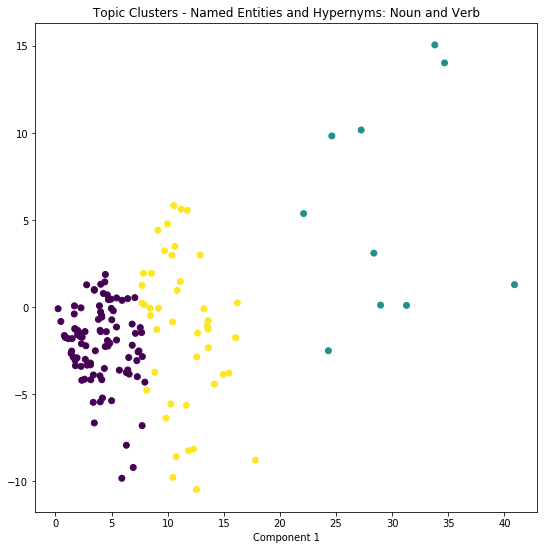

In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=3, random_state=2019).fit_predict(cvHyper)

svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(cvHyper)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters - Named Entities and Hypernyms: Noun and Verb", )
plt.show()